In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from PyUoI.UoI_Lasso import UoI_Lasso

%matplotlib inline

In [2]:
data = loadmat('data/20080516_R1.mat', struct_as_record=False)

# extract session
recording = 0
sessions = data['stimulus'].ravel()
session = sessions[recording]

# extract spikes
spikes = data['spikes']

# extract useful quantities
n_cells = np.asscalar(np.asscalar(data['datainfo']).Ncell)
n_frames = np.asscalar(session.Nframes)
frame_length = np.asscalar(session.frame)
onset = np.asscalar(session.onset)
window_length = 0.5 # in seconds
n_frames_per_window = int(np.round(window_length/frame_length))
neuron = 0

# timepoints
timestamps = np.arange(n_frames) * frame_length + onset
n_timestamps = timestamps.size - 1

# extract number of spatial dimensions
params = np.asscalar(session.param)
Nx = np.asscalar(params.x)/np.asscalar(params.dx)
Ny = np.asscalar(params.y)/np.asscalar(params.dy)
n_spatial_dims = int(Nx * Ny)

# extract design matrix
byte = np.fromfile('ran1.bin', count=n_timestamps*n_spatial_dims//8, dtype='uint8')
X = np.unpackbits(byte).astype('float32')
X = 2 * X - 1
X = X.reshape((n_timestamps, n_spatial_dims)).T

# extract response matrix
spike_times = spikes[neuron, recording]
# bin spike train
binned_spikes, _ = np.histogram(spike_times, bins=timestamps)
# put spikes in array
binned_spikes[:n_frames_per_window-1] = 0
n_spikes = np.sum(binned_spikes)
Y = binned_spikes/n_spikes

In [3]:
# load results
results = h5py.File('20080516_0_0.h5')

# Comparison of STRFs

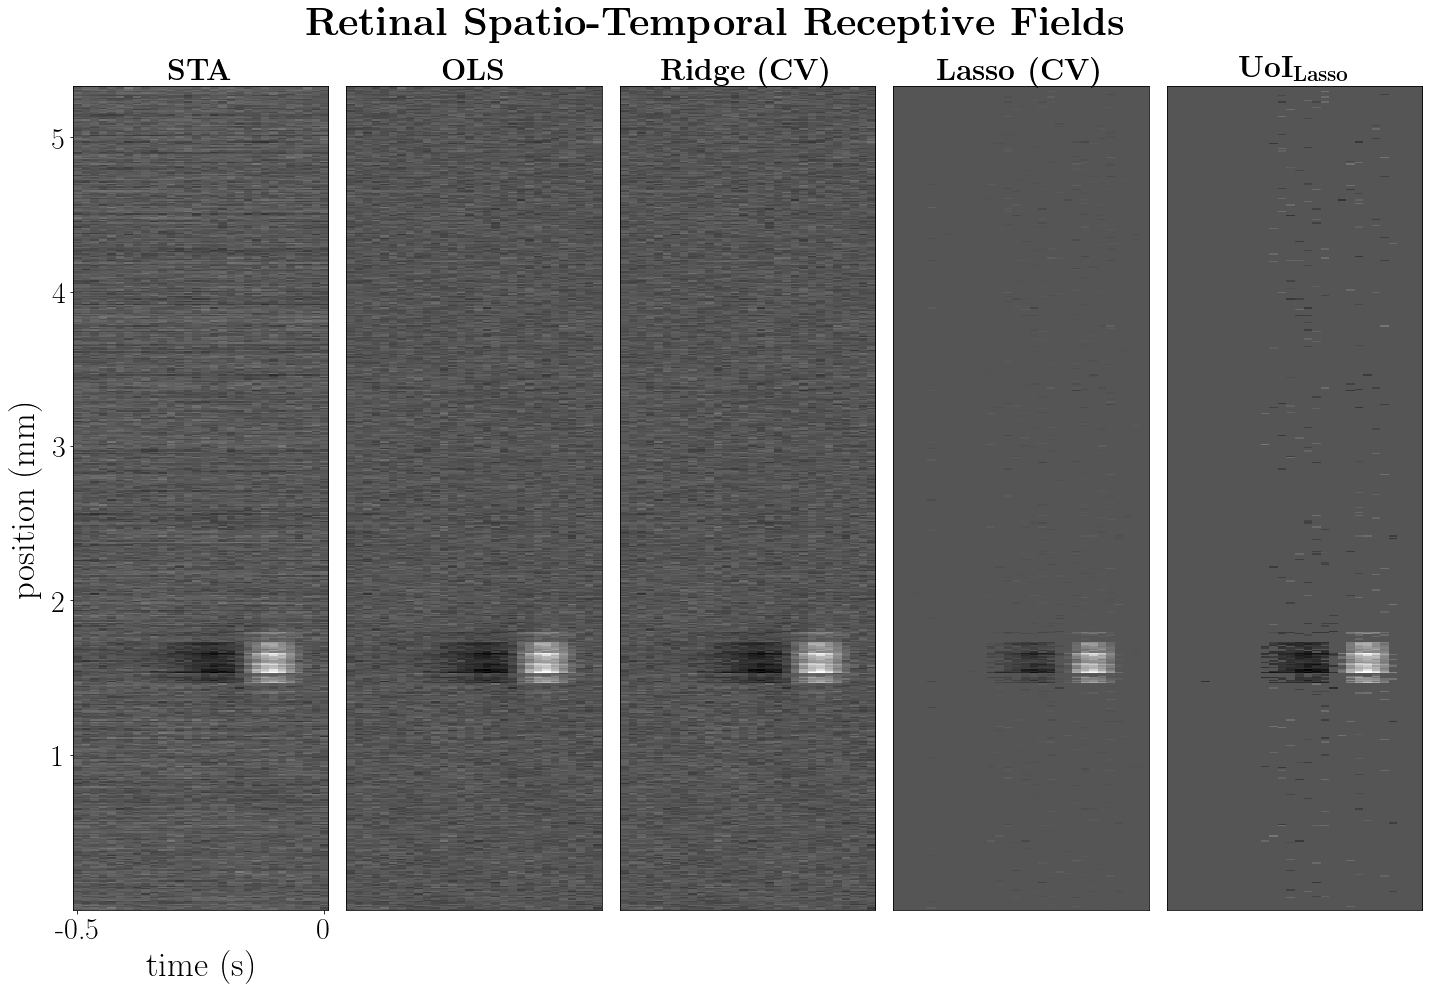

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(20, 14))

axes[0].imshow(np.flip(results['sta/strf'][:].T, axis=1), cmap='gray')
axes[0].set_title(r'\textbf{STA}')

axes[1].imshow(np.flip(results['ols/strf'][:].T, axis=1), cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[1].set_title(r'\textbf{OLS}')

axes[2].imshow(np.flip(results['ridge/strf'][:].T, axis=1), cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[2].set_title(r'\textbf{Ridge (CV)}')

axes[3].imshow(np.flip(results['lasso/strf'][:].T, axis=1), cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[3].set_title(r'\textbf{Lasso (CV)}')

axes[4].imshow(np.flip(results['uoi/strf'][:].T, axis=1), cmap='gray', vmin=-5e-7, vmax=1e-6)
axes[4].set_title(r'$\textbf{UoI}_{\textbf{Lasso}}$')
                  
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')

axes[0].set_xticks([0, 29])
axes[0].set_xticklabels([-0.5, 0], fontsize=30)
axes[0].set_xlabel(r'time (s)', fontsize=35)

dy = int(0.001/8.3e-6)
axes[0].set_yticks(np.arange(1, 6) * dy)
axes[0].set_yticklabels(np.arange(1, 6), fontsize=30)
axes[0].set_ylabel(r'position (mm)', fontsize=35, labelpad=10)

fig.suptitle(r'\textbf{Retinal Spatio-Temporal Receptive Fields}', fontsize=40)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('retina_strfs.pdf')

# Comparison of Scores/Selection Ratios

In [4]:
bics = {'ols' : np.zeros(30), 'ridge' : np.zeros(30), 'lasso' : np.zeros(30), 'uoi' : np.zeros(30)}
for method in ['ols', 'ridge', 'lasso', 'uoi']:
    coefs = results[method]['strf'][:]
    intercepts = results[method]['intercept'][:]
    print(method)
    Y_copy = np.copy(Y)
    for frame in range(30):
        bics[method][frame] = 89898 * np.log(np.mean(
            (Y_copy - intercepts[frame] - np.dot(X.T, coefs[frame]))**2
        )) + (1 + np.count_nonzero(coefs[frame])) * np.log(89898)
        Y_copy = np.roll(Y_copy, -1, axis=0)

ols
ridge
lasso
uoi


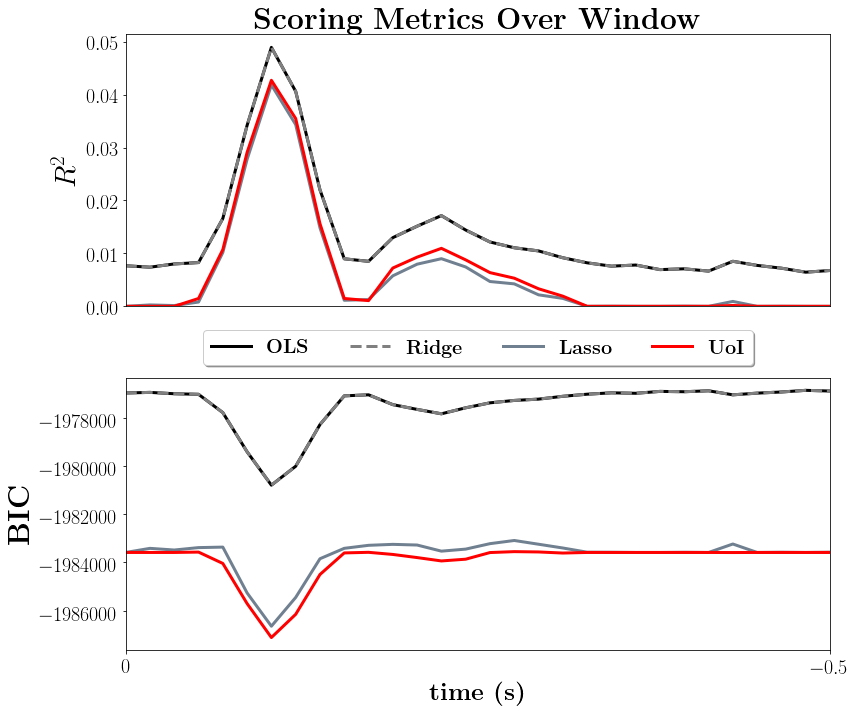

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

axes[0].plot(results['ols/r2'][:], linewidth=3, color='k', label=r'\textbf{OLS}')
axes[0].plot(results['ridge/r2'][:], linewidth=3, color='gray', linestyle='--', label=r'\textbf{Ridge}')
axes[0].plot(results['lasso/r2'][:], linewidth=3, color='slategray', label=r'\textbf{Lasso}')
axes[0].plot(results['uoi/r2'][:], linewidth=3, color='r', label=r'\textbf{UoI}')

axes[1].plot(bics['ols'], linewidth=3, color='k')
axes[1].plot(bics['ridge'], linewidth=3, color='gray', linestyle='--')
axes[1].plot(bics['lasso'], linewidth=3, color='slategray')
axes[1].plot(bics['uoi'], linewidth=3, color='r')

axes[0].set_xlim([0, 29])
axes[1].set_xlim([0, 29])   
axes[0].set_ylim(bottom=0)
axes[0].set_xticks([])
axes[1].set_xticks([0, 29])
axes[1].set_xticklabels([0, r'$-0.5$'])
axes[1].set_xlabel(r'\textbf{time (s)}')

axes[0].set_ylabel(r'$R^2$', fontsize=30)
axes[0].set_title(r'\textbf{Scoring Metrics Over Window}')
axes[1].set_ylabel(r'\textbf{BIC}', fontsize=30)
             
axes[0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.05),
    fancybox=True,
    shadow=True, 
    ncol=4,
    prop={'size' : 20}
)
plt.tight_layout()
plt.savefig('metrics.pdf')

# Selection Ratio

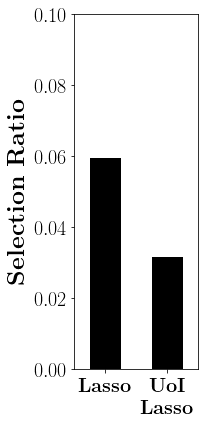

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))
ax.bar(
    x=[0, 1],
    height=[
        np.count_nonzero(results['lasso/strf'][:])/results['lasso/strf'][:].size,
        np.count_nonzero(results['uoi/strf'][:])/results['uoi/strf'][:].size
    ],
    width=0.5,
    color='k'
)
ax.set_ylim([0, 0.1])
ax.set_xlim([-0.5, 1.5])
ax.set_ylabel(r'\textbf{Selection Ratio}', fontsize=25)
ax.set_xticks([0, 1])
ax.set_xticklabels([r'\textbf{Lasso}', r'\textbf{UoI}' '\n' r'\textbf{Lasso}'])

plt.tight_layout()
plt.savefig('retina_selection_ratio.pdf')

# Histogram of STRF Values

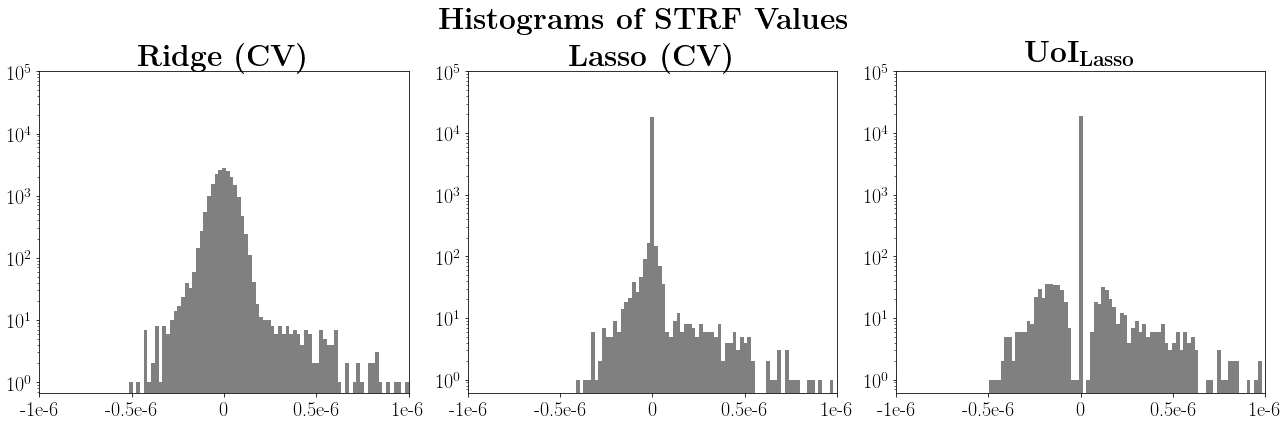

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

bins = np.linspace(-1e-6, 1e-6, 100)
axes[0].hist(results['ols/strf'][:].ravel(), color='gray', bins=bins)
axes[1].hist(results['lasso/strf'][:].ravel(), color='gray', bins=bins)
axes[2].hist(results['uoi/strf'][:].ravel(), color='gray', bins=bins)

for ax in axes.ravel():
    ax.set_xlim([-0.0000010, 0.0000010])
    ax.set_xticks([-1e-6, -0.5e-6, 0, 0.5e-6, 1e-6])
    ax.set_xticklabels(['-1e-6', '-0.5e-6', '0', '0.5e-6', '1e-6'])
    ax.set_yscale('log')
    ax.set_ylim(top=10**5)

axes[0].set_title(r'\textbf{Ridge (CV)}')
axes[1].set_title(r'\textbf{Lasso (CV)}')
axes[2].set_title(r'$\textbf{UoI}_{\textbf{Lasso}}$')

fig.suptitle(r'\textbf{Histograms of STRF Values}', fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.savefig('retina_histograms.pdf')